# MICN

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from models.embed import DataEmbedding
from models.Autoformer_EncDec import series_decomp, series_decomp_multi
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

In [82]:
data = pd.read_csv("/content/ACB.VN-BaoCao.csv")

In [83]:
# Preprocess data
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.sort_values('Date')
data.dropna(inplace=True)
close_price = data['Close'].values

In [84]:
# Split data into train and test sets
train_size = int(len(close_price) * 0.8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.reshape(-1, 1))
train_data, test_data = scaled_data[:train_size], scaled_data[train_size-1:]

In [70]:
train_data.shape, test_data.shape

((1050, 1), (264, 1))

In [64]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 90  # Length of input sequences

# Create sequences
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_train = x_train.unsqueeze(-1)  # Add feature dimension
x_test = x_test.unsqueeze(-1)    # Add feature dimension

In [85]:
def create_sequences(data):
    x, y = [], []
    for i in range(1, len(data)):
        x.append(data[i-1:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Create sequences
x_train, y_train = create_sequences(train_data)
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.unsqueeze(2)

x_test = create_sequences(test_data)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_test = x_test.unsqueeze(2)

y_test = close_price[train_size:]

TypeError: not a sequence

In [72]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([1049, 1, 1]),
 torch.Size([263, 1, 1]),
 torch.Size([1049]),
 torch.Size([263]))

In [73]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MIC(nn.Module):
    def __init__(self, configs):
        super(MIC, self).__init__()
        self.layer = nn.Linear(configs.d_model, configs.d_model)

    def forward(self, x):
        return self.layer(x)

class SeasonalPrediction(nn.Module):
    def __init__(self, configs):
        super(SeasonalPrediction, self).__init__()
        self.layer = nn.Linear(configs.d_model, configs.pred_len)

    def forward(self, x):
        return self.layer(x)

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=configs.d_model, nhead=configs.n_heads, dropout=configs.dropout),
            num_layers=configs.d_layers)
        self.decoder = nn.Linear(configs.d_model, 1)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        enc_out = self.embedding(x_enc, x_mark_enc)
        enc_out = self.encoder(enc_out)
        dec_out = self.decoder(enc_out[:, -1, :])
        return dec_out.squeeze(-1)

# Define configurations
class Configs:
    def __init__(self):
        self.enc_in = 1  # Input dimension
        self.d_model = 512  # Model dimension
        self.embed = 'timeF'  # Embedding dimension
        self.freq = 'd'  # Frequency for positional encoding
        self.dropout = 0.05  # Dropout rate
        self.n_heads = 8  # Number of attention heads
        self.d_layers = 3  # Number of encoder layers
        self.pred_len = 90  # Prediction length
        self.seq_len = train_size  # Sequence length
configs = Configs()
model = Model(configs)
model.to(device)

Model(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=T

In [58]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model

for epoch in range(20):
	model.train()
	optimizer.zero_grad()
	output = model(x_train.to(device), None, x_train.to(device), None)
	loss = criterion(output, y_train.to(device))
	loss.backward()
	optimizer.step()

model.eval()

with torch.no_grad():
    predictions = model(x_test.to(device), None, x_test.to(device), None)
    predictions = scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, pred_length))

# Reshape y_test to match predictions shape
y_test = y_test.cpu().numpy().reshape(-1, pred_length)
y_test = scaler.inverse_transform(y_test)



RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [76]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    output = model(x_train.to(device), None, x_train.to(device), None)
    loss = criterion(output, y_train.to(device))
    loss.backward()
    optimizer.step()

model.eval()

# Predict next 90 days
predictions = []
input_seq = x_test[-1].unsqueeze(0).to(device)  # Start with the last sequence from the test set

model.eval()
with torch.no_grad():
    for _ in range(configs.pred_len):
        pred = model(input_seq, None, input_seq, None)
        predictions.append(pred.item())
        new_seq = torch.cat((input_seq[:, 1:], pred.unsqueeze(0).unsqueeze(2)), dim=1)  # Slide the window
        input_seq = new_seq

# Inverse transform predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Evaluate the predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error,mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Absolute Error (MAE): 458940485.7400954
Root Mean Squared Error (RMSE): 459141071.3036352
R-squared (R2): -1143.751835552537


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error,mean_absolute_error
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MAPE
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")


RMSE: 406374894.04118156
MAE: 404127873.3064141
MAPE: 99.99543938340393%


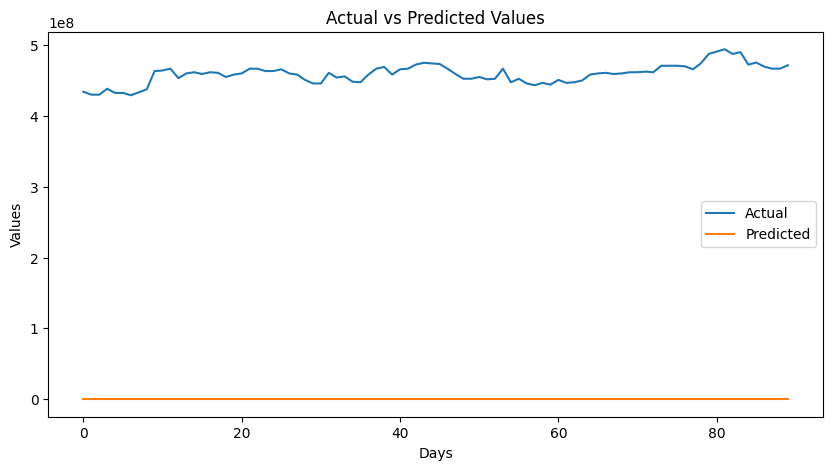

In [77]:
# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Days')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

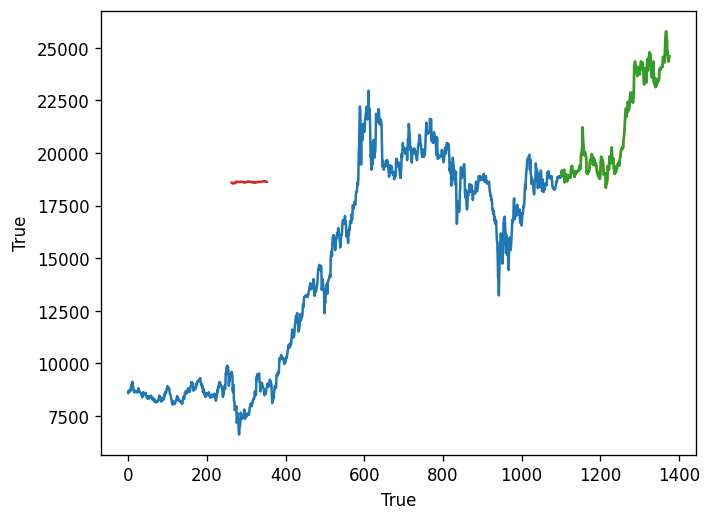

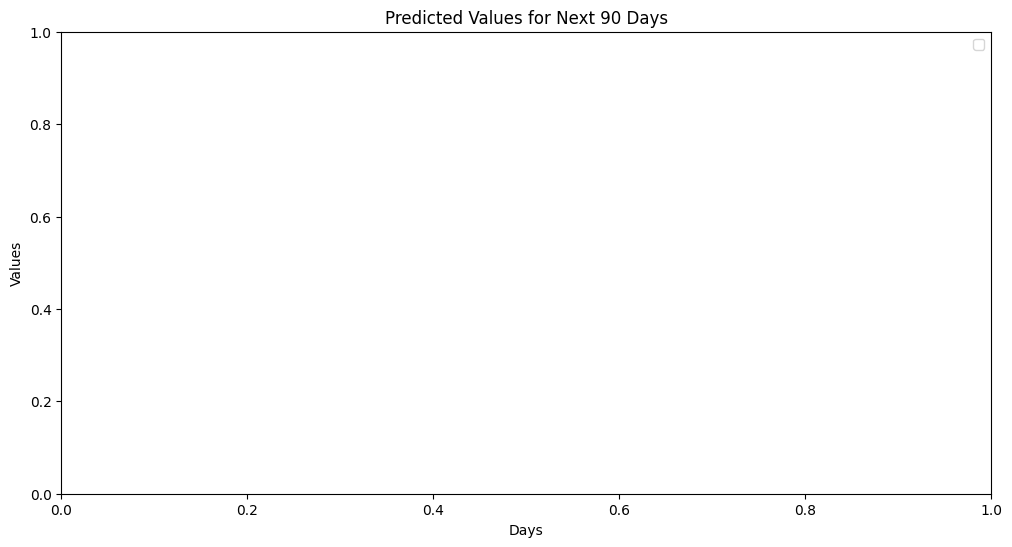

In [62]:
plt.figure(dpi=120)
plt.xlabel(data['Date'].all())
plt.ylabel(data['Close'].all())
plt.plot(data.index[:train_size], close_price[:train_size], label='Training Data')
plt.plot(data.index[train_size:], close_price[train_size:], label='Actual Data')
plt.plot(data.index[train_size:], close_price[train_size:], label='Predictions')
plt.plot(np.arange(len(y_test), len(y_test) + 90), predictions[-90:], label='Predicted for next 90 days')
plt.figure(figsize=(12, 6))

plt.xlabel('Days')
plt.ylabel('Values')
plt.title('Predicted Values for Next 90 Days')
plt.legend()
plt.show()


# Train:Test 7:3

In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [ ]:
# Convert to numpy arrays
train_data = train_data['Close'].values
test_data = test_data['Close'].values

In [ ]:
# Create sequences of data for training
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # example sequence length
X, y = create_sequences(data.values, seq_length)

# Split the data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define model parameters
dec_in = 1
c_out = 1
seq_len = seq_length
label_len = seq_length // 2
seq_length = 60  # example sequence length
label_len = 45  # example decoder input length
out_len = 15  # example prediction length
d_model = 512
n_heads = 8
d_layers = 2
dropout = 0.0
embed = 'fixed'
freq = 'd'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Initialize the model
model = MICN(
    dec_in=dec_in,
    c_out=c_out,
    seq_len=seq_len,
    label_len=label_len,
    out_len=out_len,
    d_model=d_model,
    n_heads=n_heads,
    d_layers=d_layers,
    dropout=dropout,
    embed=embed,
    freq=freq,
    device=device,
    decomp_kernel=[33],
    conv_kernel=[12, 24],
    isometric_kernel=[18, 6]
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_enc = x_batch
        x_dec = x_batch[:, -label_len:, :]  # Example for x_dec
        optimizer.zero_grad()
        output = model(x_enc, None, x_dec, None)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}')

# Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_enc = x_batch
        x_dec = x_batch[:, -label_len:, :]
        output = model(x_enc, None, x_dec, None)
        loss = criterion(output.squeeze(), y_batch)
        test_loss += loss.item() * x_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Inverse transform predictions for plotting or further analysis
predicted = scaler.inverse_transform(output.cpu().numpy())
actual = scaler.inverse_transform(y_test.cpu().numpy())

TypeError: MICN.forward() missing 3 required positional arguments: 'x_mark_enc', 'x_dec', and 'x_mark_dec'

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
d_model = 512
n_heads = 8
d_layers = 2
dropout = 0.1
decomp_kernel = [32]
conv_kernel = [24]
isometric_kernel = [18, 6]
seq_len = seq_length
out_len = pred_length

# Initialize the model
model = MICN(dec_in=1, c_out=1, seq_len=seq_len, label_len=0, out_len=out_len,
             d_model=d_model, n_heads=n_heads, d_layers=d_layers, dropout=dropout,
             embed='fixed', freq='d', device=device, mode='regre',
             decomp_kernel=decomp_kernel, conv_kernel=conv_kernel, isometric_kernel=isometric_kernel).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_enc = x_batch
        x_dec = x_batch[:, -label_len:, :]  # Example for x_dec
        optimizer.zero_grad()
        output = model(x_enc, None, x_dec, None)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}')

    # Evaluate on test data
    model.eval()
    test_loss = 0
    with torch.no_grad():
      for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_enc = x_batch
        x_dec = x_batch[:, -label_len:, :]
        output = model(x_enc, None, x_dec, None)
        loss = criterion(output.squeeze(), y_batch)
        test_loss += loss.item() * x_batch.size(0)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

# Inverse transform predictions for plotting or further analysis
predicted = scaler.inverse_transform(output.cpu().numpy())
actual = scaler.inverse_transform(y_test.cpu().numpy())

RuntimeError: The size of tensor a (60) must match the size of tensor b (59) at non-singleton dimension 1

In [ ]:
# Create sequences of data for training
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])
    return np.array(X), np.array(y)

seq_len = 60  # Length of the input sequence
pred_len = 30  # Length of the prediction sequence
X, y = create_sequences(scaled_data, seq_len, pred_len)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        optimizer.zero_grad()
        output = model(X_batch, None, X_batch, None)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

# Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        output = model(X_batch, None, X_batch, None)
        loss = criterion(output, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')



AttributeError: 'NoneType' object has no attribute 'long'

In [ ]:
# Chia dữ liệu thành tập train, tập test và tập validation
train_size = int(len(scaled_data) * 0.7)
test_size = int(len(scaled_data) * 0.3)

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_time_series(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step)])
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_time_series(train_data, time_step)
X_test, y_test = create_time_series(test_data, time_step)
X_validate, y_validate = create_time_series(validate_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], 1)

In [ ]:
print("Training set size:", X_train.shape)
print("Validation set size:", X_validate.shape)
print("Test set size:", X_test.shape)

Training set size: (772, 100, 1)
Validation set size: (25, 100, 1)
Test set size: (149, 100, 1)


In [ ]:
import torch
import torch.nn as nn
from models.embed import DataEmbedding
from models.local_global import Seasonal_Prediction, series_decomp_multi

In [ ]:
input_shape = (time_step, 1)
model = MICN(input_shape)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 100, 32)              128       ['input_3[0][0]']             
                                                                                                  
 conv1d_7 (Conv1D)           (None, 100, 32)              192       ['input_3[0][0]']             
                                                                                                  
 conv1d_8 (Conv1D)           (None, 100, 32)              256       ['input_3[0][0]']             
                                                                                            

# Cách khác

In [ ]:
# Kết hợp đầu ra Attention với đầu ra LSTM
concat_out = Concatenate()([lstm_out, attention_out])

In [ ]:
# Thêm một LSTM layer và Dense layer
lstm_out2 = LSTM(50, return_sequences=False)(concat_out)
output = Dense(1)(lstm_out2)

In [ ]:
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Bước 3: Huấn luyện mô hình
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
14/14 [==============================] - 6s 209ms/step - loss: 0.0968 - val_loss: 0.0052
Epoch 2/100
14/14 [==============================] - 3s 183ms/step - loss: 0.0118 - val_loss: 0.0042
Epoch 3/100
14/14 [==============================] - 2s 123ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 4/100
14/14 [==============================] - 2s 110ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 5/100
14/14 [==============================] - 2s 110ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 6/100
14/14 [==============================] - 2s 111ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 7/100
14/14 [==============================] - 2s 111ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 8/100
14/14 [==============================] - 2s 109ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 9/100
14/14 [==============================] - 2s 182ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/100
14/14 [==============================] - 2s 141ms/step - loss: 0.0027 - val_lo

In [ ]:
# Bước 4: Dự báo
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


5/5 [==============================] - 1s 37ms/step


In [ ]:
# Đảo ngược giá trị chuẩn hóa để so sánh với dữ liệu gốc
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Bước 5: Đánh giá mô hình
import math
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 606.8885519921954
Test RMSE: 461.965541476855


In [ ]:
import matplotlib.pyplot as plt

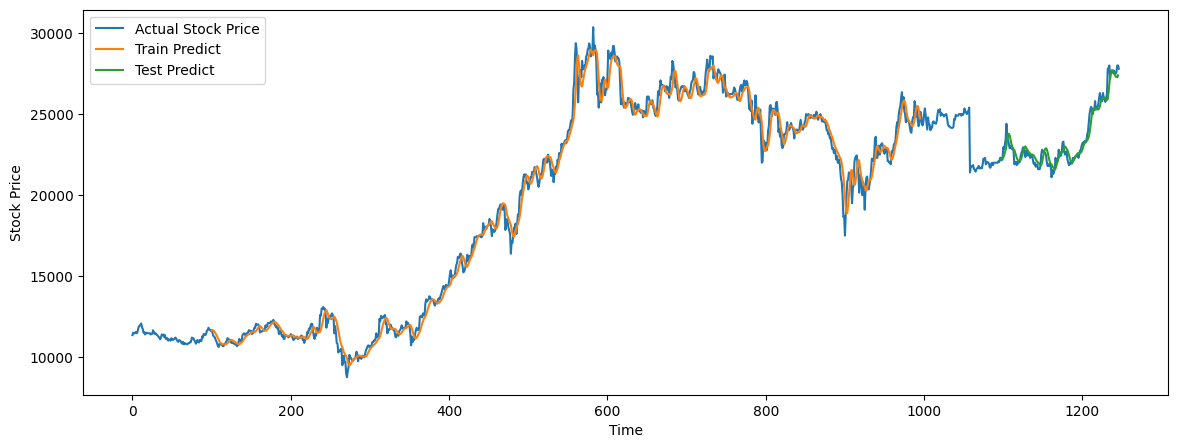

In [ ]:
# Bước 6: Vẽ biểu đồ
# Dữ liệu thực tế cho tập huấn luyện
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict)+time_step, :] = train_predict

# Dữ liệu thực tế cho tập kiểm tra
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_step*2)+1:len(scaled_data)-1, :] = test_predict

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Price')
plt.plot(train_plot, label='Train Predict')
plt.plot(test_plot, label='Test Predict')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Bước 7: Dự đoán 7 ngày tiếp theo
last_input = test_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []

for _ in range(7):
    next_pred = model.predict(last_input)
    future_predictions.append(next_pred[0, 0])

    # Tạo next_input có số chiều phù hợp
    next_input = np.append(last_input[:, 1:, :], np.reshape(next_pred, (1, 1, 1)), axis=1)
    last_input = next_input

# Đảo ngược giá trị chuẩn hóa dự đoán
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 27ms/step


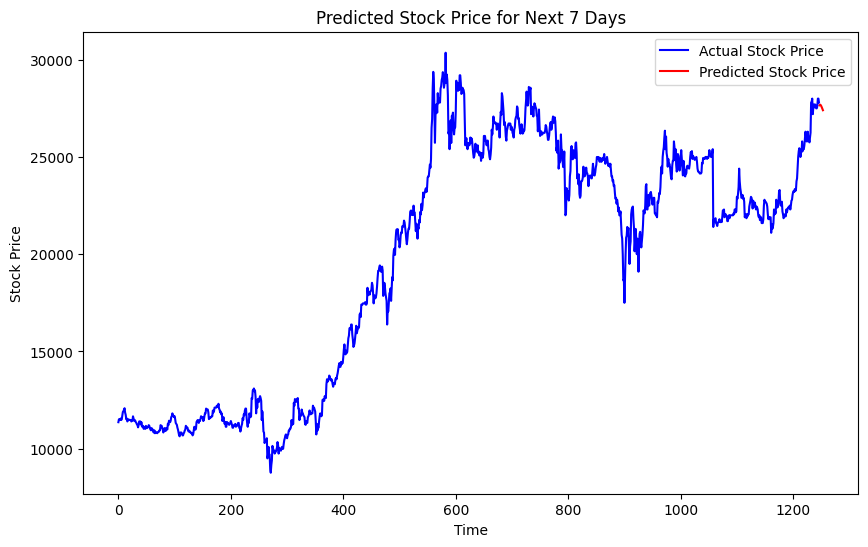

In [ ]:
# Biểu đồ dự đoán cho 7 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(scaled_data)), scaler.inverse_transform(scaled_data), label='Actual Stock Price', color='blue')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + 7), future_predictions, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Predicted Stock Price for Next 7 Days')
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step


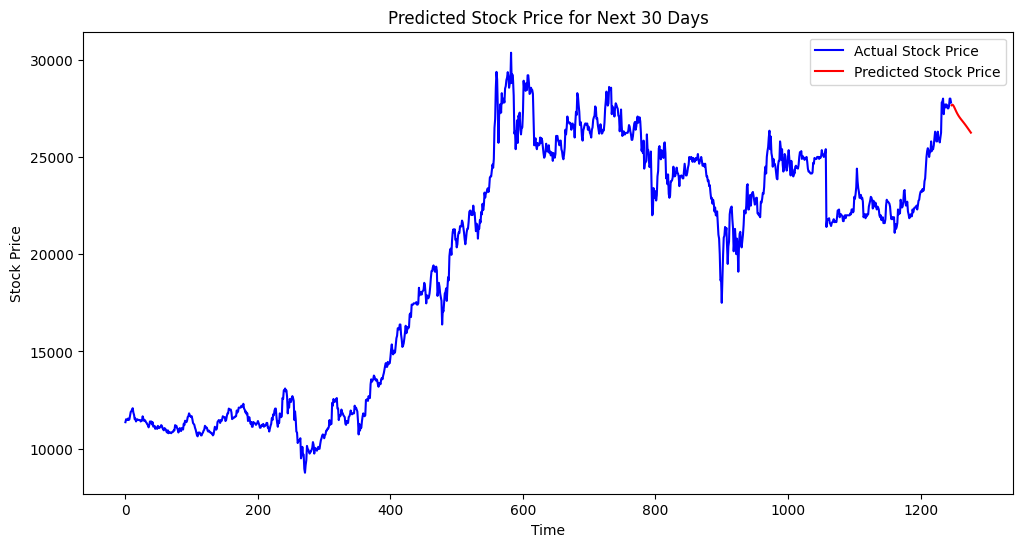

In [ ]:
# Dự đoán 30 ngày tiếp theo
last_input = test_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []

for _ in range(30):
    next_pred = model.predict(last_input)
    future_predictions.append(next_pred[0, 0])

    # Tạo next_input có số chiều phù hợp
    next_input = np.append(last_input[:, 1:, :], np.reshape(next_pred, (1, 1, 1)), axis=1)
    last_input = next_input

# Đảo ngược giá trị chuẩn hóa dự đoán
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Biểu đồ dự đoán cho 30 ngày tiếp theo
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(scaled_data)), scaler.inverse_transform(scaled_data), label='Actual Stock Price', color='blue')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + 30), future_predictions, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Predicted Stock Price for Next 30 Days')
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step


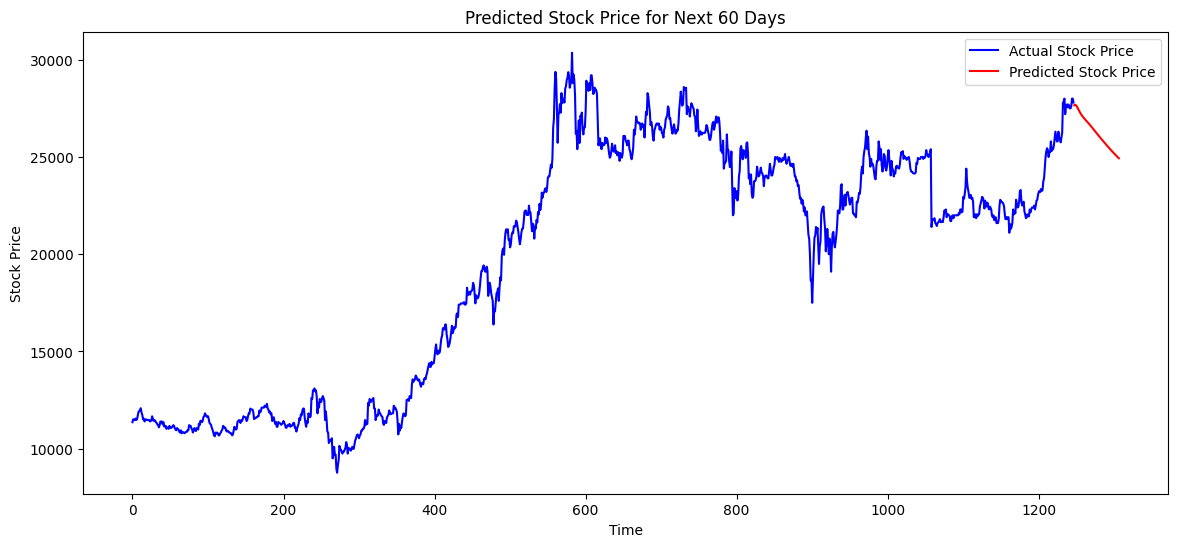

In [ ]:
# Dự đoán 60 ngày tiếp theo
last_input = test_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []

for _ in range(60):
    next_pred = model.predict(last_input)
    future_predictions.append(next_pred[0, 0])

    # Tạo next_input có số chiều phù hợp
    next_input = np.append(last_input[:, 1:, :], np.reshape(next_pred, (1, 1, 1)), axis=1)
    last_input = next_input

# Đảo ngược giá trị chuẩn hóa dự đoán
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Biểu đồ dự đoán cho 60 ngày tiếp theo
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(scaled_data)), scaler.inverse_transform(scaled_data), label='Actual Stock Price', color='blue')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + 60), future_predictions, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Predicted Stock Price for Next 60 Days')
plt.legend()
plt.show()